# Setting

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/b2018yniki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
print('Pytorch version: ', torch.__version__)
print('Currently selected device: ', torch.cuda.current_device())
print('# GPUs available: ', torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu') # デバッグ用
print(device)

Pytorch version:  1.1.0
Currently selected device:  0
# GPUs available:  2
cuda:0


# Dataset作成に必要なclassおよびfunction

## 分かち書き

In [17]:
spacy_en = spacy.load('en')
def tokenizer(text):
    soup = BeautifulSoup(text)
    clean_txt = soup.get_text()
    words = []
    for token in spacy_en.tokenizer(clean_txt):
        if token.text not in "[],.();:<>{}|*-~":
        # if (token.text not in "[],.();:<>{}|*-~") & (token.text not in stopwords.words('english')):
            words.append(token.text)
    return words

## torknize

In [4]:
def df2indexseq(df, vocab_idx):
    data = []
    for text in df.body.values:
        words = tokenizer(text)
        data.append([vocab_idx[word]+1 for word in words if word in vocab_idx.keys()])
    return data

## Padding

In [5]:
def padding(data):
    # npに変換し、0埋めを行う
    max_length = max([len(d) for d in data])
    padded_data = np.zeros((len(data), max_length))
    for i, d1 in enumerate(data):
        for j, d2 in enumerate(d1):
            padded_data[i][j] = d2
    return padded_data

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, tags):
        super(MyDataset, self).__init__()
        super(MyDataset, self).__init__()
        assert len(data) == len(tags)
        self.data = data
        self.tags = tags

    def __len__(self):
        return len(self.tags)

    def __getitem__(self, index):
        return self.data[index], self.tags[index]

# Model

## LSTM \w self-attention

In [6]:
class ATT(nn.Module):
    def __init__(self, hidden_dim):
        super(ATT, self).__init__()
        self.hidden_dim = hidden_dim
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, inputs):
        b_size = inputs.size(0)
        inputs = inputs.contiguous().view(-1, self.hidden_dim)
        att = self.fc(torch.tanh(inputs))
        return F.softmax(att.view(b_size, -1), dim=1).unsqueeze(2)
    
class LSTM(nn.Module):
    def __init__(self, batch_size, vocab_size, emb_dim, hidden_dim, dropout_rate=0.0, activate='tanh', bidirectional=False, device='cpu'):
        super(LSTM, self).__init__()
        
        self.vocab_size = vocab_size
        self.emb_dim    = emb_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.bidirectional = bidirectional
        self.activate   = activate
        
        self.emb  = nn.Embedding(self.vocab_size, self.emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(self.emb_dim, self.hidden_dim, batch_first=True, bidirectional=self.bidirectional)
        self.att = ATT(hidden_dim * 2)
        
        self.fc0 = nn.Linear(hidden_dim * 2, 100)
        self.fc1 = nn.Linear(100, 2)
        self.do  = nn.Dropout(dropout_rate)
        self.device = device
        self.hidden = self.init_hidden()

    def forward(self, x):

        x = self.emb(x)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        
        att = self.att(lstm_out)
        feats = (lstm_out * att).sum(dim=1) # (b, s, h) -> (b, h)
        
        y = self.fc0(feats)
        y = self.do(y)
        if self.activate == 'tanh':
            y = self.fc1(torch.tanh(y))
        elif self.activate == 'relu':
            y = self.fc1(F.relu(y))
        tag_scores = F.log_softmax(y)
        return tag_scores, att

    def init_hidden(self):
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        num = 2 if self.bidirectional else 1    # bidirectionalのとき2
        h0 = torch.zeros(num, self.batch_size, self.hidden_dim).to(self.device)
        c0 = torch.zeros(num, self.batch_size, self.hidden_dim).to(self.device)
        return (h0, c0)

## plot accuracy and loss

In [7]:
def training_plot(epoch_num, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list):
    plt.figure()
    plt.plot(range(epoch_num), train_loss_list, color='blue', linestyle='-', label='train_loss')
    plt.plot(range(epoch_num), valid_loss_list, color='green', linestyle='--', label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training and validation loss')
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(range(epoch_num), train_acc_list, color='blue', linestyle='-', label='train_acc')
    plt.plot(range(epoch_num), valid_acc_list, color='green', linestyle='--', label='val_acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('Training and validation accuracy')
    plt.grid()
    plt.show()

## Train

In [8]:
def training(net, train_loader, valid_loader, epoch_num, y_valid):

    train_loss_list = []
    train_acc_list  = []
    valid_loss_list = []
    valid_acc_list  = []
    
    for epoch in range(epoch_num):

        train_loss = 0.0
        train_acc  = 0.0
        valid_loss = 0.0
        valid_acc  = 0.0

        # train====================
        net.train()
        for xx, yy in train_loader:
            # xx, yy = xx.long().to(device), yy.to(device)

            net.batch_size = len(yy)
            net.hidden = net.init_hidden()

            optimizer.zero_grad()    # 勾配の初期化

            output, att = net(xx)
            loss   = criterion(output, yy)

            train_loss += loss.item()
            train_acc += (output.max(1)[1] == yy).sum().item()

            loss.backward(retain_graph=True)     # 逆伝播の計算
            optimizer.step()    # 勾配の更新
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_acc  = train_acc  / len(train_loader.dataset)
            
        # eval========================
        net.eval()
        y_pred = []
        with torch.no_grad():
            for xx, yy in valid_loader:
                # xx, yy = xx.long().to(device), yy.to(device)

                net.batch_size = len(yy)
                net.hidden = net.init_hidden()

                output, att = net(xx)
                loss   = criterion(output, yy)

                valid_loss += loss.item()
                valid_acc  += (output.max(1)[1] == yy).sum().item()
                y_pred += output.data.max(1, keepdim=True)[1].to('cpu').numpy()[:,0].tolist()
                
        avg_valid_loss = valid_loss / len(valid_loader.dataset)
        avg_valid_acc  = valid_acc  / len(valid_loader.dataset)
        
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        valid_loss_list.append(avg_valid_loss)
        valid_acc_list.append(avg_valid_acc)
        
    training_plot(epoch_num, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)

## Test

In [9]:
def test(net, test_loader, y_test):
    net.eval()
    y_pred = []
    with torch.no_grad():
        for xx, yy in test_loader:
            # xx, yy = xx.long().to(device), yy.to(device)

            net.batch_size = len(yy)
            net.hidden = net.init_hidden()

            output, att = net(xx)
            y_pred += output.data.max(1, keepdim=True)[1].to('cpu').numpy()[:,0].tolist()

    acc = accuracy_score(y_pred, y_test)
    result = precision_recall_fscore_support(y_test, y_pred, average='macro')
    return [acc, result[0], result[1], result[2]]

# Results of GridSearch

In [10]:
gs_df = pd.read_csv('results/gridsearch_lstm_attention_end2end.csv').sort_values('f1', ascending=False).head(5)
gs_df

,epoch,batch_size,embedding_dim,hidden_dim,activate_func,learning_rate,l2_regular,dropout_rate,accuracy,precision,recall,f1
472,200,64,300,100,tanh,0.1,0.001,0.25,0.967979,0.937246,0.908146,0.922005
5,300,64,100,100,tanh,0.1,0.001,0.00,0.966875,0.935012,0.904888,0.919204
455,300,64,300,100,relu,0.1,0.001,0.00,0.965771,0.927477,0.908205,0.917532
185,300,64,100,200,tanh,0.1,0.001,0.50,0.966875,0.944467,0.894367,0.917374
41,300,64,100,100,tanh,0.1,0.001,0.25,0.966139,0.937680,0.897894,0.916486


# Experiments

## Case1
the random seed of train_test_split is 2019

In [18]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [1 if 'Cause-Effect' in relation else 0 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

vocab = []
for text in train_df.body.values:
    vocab.extend(tokenizer(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = torch.LongTensor(padding(df2indexseq(train_df, vocab_idx))).to(device)
X_test  = torch.LongTensor(padding(df2indexseq(test_df, vocab_idx))).to(device)
y_train = torch.LongTensor(train_df.causal_flag.values).to(device)
y_test  = torch.LongTensor(test_df.causal_flag.values).to(device)
# y_train = train_df.causal_flag.values
# y_test  = test_df.causal_flag.values

del train_df, test_df

train_ds = MyDataset(X_train, y_train)
test_ds  = MyDataset(X_test, y_test)

del X_train, X_test

vocabulaly size: 21100


LSTM(
  (emb): Embedding(21101, 300, padding_idx=0)
  (lstm): LSTM(300, 100, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=200, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=200, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.25)
)


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


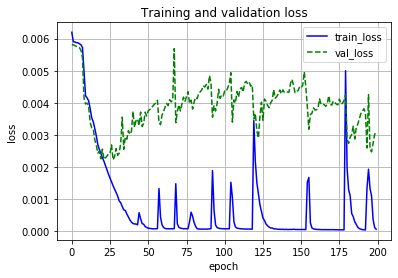

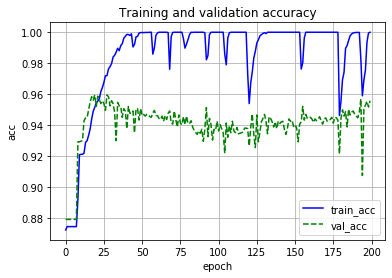

Accuracy: 0.9558336400441664, Precision: 0.9025294525294525, Recall: 0.8854582486804358, F1: 0.8937343554443054


In [19]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 200
batch_size = 64
vocab_size = len(vocab_idx)+1
emb_dim    = 300
hidden_dim = 100
activate   = 'tanh'
drop_rate  = 0.25
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

np.random.seed(2019)
np.random.RandomState(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

print(net)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

training(net, train_loader, test_loader, epoch, y_test)
result = test(net, test_loader, y_test.to('cpu').numpy().tolist())
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

In [13]:
torch.save(net.state_dict(), 'best_params/lstm_att_s2019.prm')

In [14]:
del net, criterion, optimizer

In [15]:
net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
net.load_state_dict(torch.load('best_params/lstm_att_s2019.prm'))
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

Accuracy: 0.8183632734530938, Precision: 0.8141402714932127, Recall: 0.8165033052199681, F1: 0.8151553852703277


/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [17]:
del net, train_ds, test_ds, train_loader, test_loader

## Case2
the random seed of train_test_split is 2020

In [18]:
train_df = pd.read_csv('/home/b2018yniki/data/nikkei/train.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
test_df  = pd.read_csv('/home/b2018yniki/data/nikkei/test.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
total_df = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates()

X = total_df.body
y = total_df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2020)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(get_tango(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2input(X_train, vocab_idx)
X_test  = df2input(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train.values)
test_ds  = MyDataset(X_test, y_test.values)

del X_train, X_test

vocabulaly size: 9741


In [19]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'relu'
drop_rate  = 0.5
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

print(net)

training(net, train_loader, epoch)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

LSTM(
  (emb): Embedding(9746, 300)
  (lstm): LSTM(300, 200, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=400, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=400, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.5)
)


/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.8203592814371258, Precision: 0.8175164947793223, Recall: 0.8210434275721363, F1: 0.8186242960579244


In [20]:
torch.save(net.state_dict(), 'best_params/lstm_att_s2020.prm')
del net, criterion, optimizer

In [21]:
net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
net.load_state_dict(torch.load('best_params/lstm_att_s2020.prm'))
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

del net, train_ds, test_ds, train_loader, test_loader

/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.8203592814371258, Precision: 0.8175164947793223, Recall: 0.8210434275721363, F1: 0.8186242960579244


## Case3
the random seed of train_test_split is 1996

In [11]:
train_df = pd.read_csv('/home/b2018yniki/data/nikkei/train.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
test_df  = pd.read_csv('/home/b2018yniki/data/nikkei/test.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
total_df = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates()

X = total_df.body
y = total_df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1996)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(get_tango(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2input(X_train, vocab_idx)
X_test  = df2input(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train.values)
test_ds  = MyDataset(X_test, y_test.values)

del X_train, X_test

vocabulaly size: 9647


In [12]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'relu'
drop_rate  = 0.5
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

print(net)

training(net, train_loader, epoch)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

LSTM(
  (emb): Embedding(9647, 300)
  (lstm): LSTM(300, 200, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=400, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=400, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.5)
)


/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.7984031936127745, Precision: 0.793888604025125, Recall: 0.8005341810316576, F1: 0.7954697030327282


In [13]:
torch.save(net.state_dict(), 'best_params/lstm_att_s1996.prm')
del net, criterion, optimizer

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
net.load_state_dict(torch.load('best_params/lstm_att_s1996.prm'))
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

del net, train_ds, test_ds, train_loader, test_loader

/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.7984031936127745, Precision: 0.793888604025125, Recall: 0.8005341810316576, F1: 0.7954697030327282


## Case4
the random seed of train_test_split is 1192

In [11]:
train_df = pd.read_csv('/home/b2018yniki/data/nikkei/train.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
test_df  = pd.read_csv('/home/b2018yniki/data/nikkei/test.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
total_df = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates()

X = total_df.body
y = total_df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1192)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(get_tango(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2input(X_train, vocab_idx)
X_test  = df2input(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train.values)
test_ds  = MyDataset(X_test, y_test.values)

del X_train, X_test

vocabulaly size: 9773


In [12]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'relu'
drop_rate  = 0.5
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

print(net)

training(net, train_loader, epoch)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

LSTM(
  (emb): Embedding(9773, 300)
  (lstm): LSTM(300, 200, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=400, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=400, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.5)
)


/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.8183632734530938, Precision: 0.8134097319026161, Recall: 0.8159911750285995, F1: 0.8145327621767412


In [13]:
torch.save(net.state_dict(), 'best_params/lstm_att_s1192.prm')
del net, criterion, optimizer, vocab_idx

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
net.load_state_dict(torch.load('best_params/lstm_att_s1192.prm'))
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

del net, train_ds, test_ds, train_loader, test_loader

Accuracy: 0.8183632734530938, Precision: 0.8134097319026161, Recall: 0.8159911750285995, F1: 0.8145327621767412


/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Case5
the random seed of train_test_split is 794

In [11]:
train_df = pd.read_csv('/home/b2018yniki/data/nikkei/train.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
test_df  = pd.read_csv('/home/b2018yniki/data/nikkei/test.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
total_df = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates()

X = total_df.body
y = total_df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=794)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(get_tango(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2input(X_train, vocab_idx)
X_test  = df2input(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train.values)
test_ds  = MyDataset(X_test, y_test.values)

del X_train, X_test

vocabulaly size: 9708


In [12]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'relu'
drop_rate  = 0.5
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

print(net)

training(net, train_loader, epoch)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

LSTM(
  (emb): Embedding(9708, 300)
  (lstm): LSTM(300, 200, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=400, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=400, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.5)
)


/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.5808383233532934, Precision: 0.291, Recall: 0.4982876712328767, F1: 0.3674242424242424


## Case6
the random seed of train_test_split is 2000

In [13]:
train_df = pd.read_csv('/home/b2018yniki/data/nikkei/train.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
test_df  = pd.read_csv('/home/b2018yniki/data/nikkei/test.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
total_df = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates()

X = total_df.body
y = total_df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2000)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(get_tango(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2input(X_train, vocab_idx)
X_test  = df2input(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train.values)
test_ds  = MyDataset(X_test, y_test.values)

del X_train, X_test

vocabulaly size: 9758


In [14]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'relu'
drop_rate  = 0.5
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

print(net)

training(net, train_loader, epoch)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

LSTM(
  (emb): Embedding(9758, 300)
  (lstm): LSTM(300, 200, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=400, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=400, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.5)
)


/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.8183632734530938, Precision: 0.8156207827260459, Recall: 0.8174773755656108, F1: 0.8163852160920189


In [15]:
torch.save(net.state_dict(), 'best_params/lstm_att_s2000.prm')
del net, criterion, optimizer, vocab_idx

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
net.load_state_dict(torch.load('best_params/lstm_att_s2000.prm'))
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

del net, train_ds, test_ds, train_loader, test_loader

/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.8183632734530938, Precision: 0.8156207827260459, Recall: 0.8174773755656108, F1: 0.8163852160920189


## Case7
the random seed of train_test_split is 1945

In [16]:
train_df = pd.read_csv('/home/b2018yniki/data/nikkei/train.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
test_df  = pd.read_csv('/home/b2018yniki/data/nikkei/test.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
total_df = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates()

X = total_df.body
y = total_df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1945)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(get_tango(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2input(X_train, vocab_idx)
X_test  = df2input(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train.values)
test_ds  = MyDataset(X_test, y_test.values)

del X_train, X_test

vocabulaly size: 9754


In [17]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'relu'
drop_rate  = 0.5
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

print(net)

training(net, train_loader, epoch)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

LSTM(
  (emb): Embedding(9754, 300)
  (lstm): LSTM(300, 200, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=400, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=400, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.5)
)


/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.8063872255489022, Precision: 0.805620402942117, Recall: 0.8057670772676372, F1: 0.8056905010375808


In [18]:
torch.save(net.state_dict(), 'best_params/lstm_att_s1945.prm')
del net, criterion, optimizer, vocab_idx

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
net.load_state_dict(torch.load('best_params/lstm_att_s1945.prm'))
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

del net, train_ds, test_ds, train_loader, test_loader

Accuracy: 0.8063872255489022, Precision: 0.805620402942117, Recall: 0.8057670772676372, F1: 0.8056905010375808


/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Case8
the random seed of train_test_split is 5748

In [19]:
train_df = pd.read_csv('/home/b2018yniki/data/nikkei/train.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
test_df  = pd.read_csv('/home/b2018yniki/data/nikkei/test.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
total_df = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates()

X = total_df.body
y = total_df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5748)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(get_tango(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2input(X_train, vocab_idx)
X_test  = df2input(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train.values)
test_ds  = MyDataset(X_test, y_test.values)

del X_train, X_test

vocabulaly size: 9724


In [20]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'relu'
drop_rate  = 0.5
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

print(net)

training(net, train_loader, epoch)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

LSTM(
  (emb): Embedding(9724, 300)
  (lstm): LSTM(300, 200, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=400, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=400, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.5)
)


/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.8163672654690619, Precision: 0.8150510204081632, Recall: 0.8206334782890894, F1: 0.8152477152477153


In [21]:
torch.save(net.state_dict(), 'best_params/lstm_att_s5748.prm')
del net, criterion, optimizer, vocab_idx

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
net.load_state_dict(torch.load('best_params/lstm_att_s5748.prm'))
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

del net, train_ds, test_ds, train_loader, test_loader

Accuracy: 0.8163672654690619, Precision: 0.8150510204081632, Recall: 0.8206334782890894, F1: 0.8152477152477153


/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Case9
the random seed of train_test_split is 7248

In [22]:
train_df = pd.read_csv('/home/b2018yniki/data/nikkei/train.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
test_df  = pd.read_csv('/home/b2018yniki/data/nikkei/test.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
total_df = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates()

X = total_df.body
y = total_df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7248)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(get_tango(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2input(X_train, vocab_idx)
X_test  = df2input(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train.values)
test_ds  = MyDataset(X_test, y_test.values)

del X_train, X_test

vocabulaly size: 9796


In [23]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'relu'
drop_rate  = 0.5
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

print(net)

training(net, train_loader, epoch)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

LSTM(
  (emb): Embedding(9796, 300)
  (lstm): LSTM(300, 200, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=400, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=400, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.5)
)


/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.7984031936127745, Precision: 0.7907616659611189, Recall: 0.7952028300327305, F1: 0.7925720961692185


## Case10
the random seed of train_test_split is 8787

In [11]:
train_df = pd.read_csv('/home/b2018yniki/data/nikkei/train.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
test_df  = pd.read_csv('/home/b2018yniki/data/nikkei/test.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
total_df = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates()

X = total_df.body
y = total_df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7248)
del train_df, test_df, total_df, X, y

vocab = []
for text in X_train.values:
    vocab.extend(get_tango(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

X_train = df2input(X_train, vocab_idx)
X_test  = df2input(X_test, vocab_idx)

train_ds = MyDataset(X_train, y_train.values)
test_ds  = MyDataset(X_test, y_test.values)

del X_train, X_test

vocabulaly size: 9796


In [12]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

# hyperparameter
epoch      = 300
batch_size = 64
vocab_size = len(vocab_idx)
emb_dim    = 300
hidden_dim = 200
activate   = 'relu'
drop_rate  = 0.5
lr = 0.1
l2 = 0.001

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=l2)

print(net)

training(net, train_loader, epoch)
result = test(net, test_loader, y_test)
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

LSTM(
  (emb): Embedding(9796, 300)
  (lstm): LSTM(300, 200, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=400, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=400, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.5)
)


/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.7964071856287425, Precision: 0.7904090675571539, Recall: 0.799021390551129, F1: 0.7924707602339182


In [ ]:
# torch.save(net.state_dict(), 'best_params/lstm_att_s8787.prm')
# del net, criterion, optimizer, vocab_idx

# net = LSTM(batch_size, vocab_size, emb_dim, hidden_dim, drop_rate, activate, bidirectional=True, device=device).to(device)
# net.load_state_dict(torch.load('best_params/lstm_att_s8787.prm'))
# result = test(net, test_loader, y_test)
# print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))

# del net, train_ds, test_ds, train_loader, test_loader